In [1137]:
from IPython.display import display
import copy
import math
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [1138]:
RANDOM_SEED = 42  # Фиксируем seed

In [1139]:
df_train = pd.read_csv('data/main_task.csv')
df_test = pd.read_csv('data/kaggle_task.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [1140]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


Подробнее по признакам:

City: Город

Cuisine Style: Кухня

Ranking: Ранг ресторана относительно других ресторанов в этом городе

Price Range: Цены в ресторане в 3 категориях

Number of Reviews: Количество отзывов

Reviews: 2 последних отзыва и даты этих отзывов

URL_TA: страница ресторана на 'www.tripadvisor.com'

ID_TA: ID ресторана в TripAdvisor

Rating: Рейтинг ресторана

In [1141]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [1142]:
df_train['sample'] = 1  # трейн
df_test['sample'] = 0  # тест
# в тесте у нас нет значения Rating, мы его должны предсказать, просто заполняем нулями
df_test['Rating'] = 0

data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем

In [1143]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
28264,id_293,Zurich,"['Italian', 'Bar', 'European', 'Vegetarian Fri...",295.0,$$ - $$$,57.0,"[['AWESOME place', 'Perfect Italian in lively ...",/Restaurant_Review-g188113-d4973470-Reviews-Ma...,d4973470,1,4.5
48018,id_4391,London,"['British', 'Gluten Free Options', 'Vegetarian...",4398.0,$$ - $$$,144.0,[['Lovely meal in friendly neighbourhood rest....,/Restaurant_Review-g186338-d802292-Reviews-Fra...,d802292,1,4.0
21102,id_2125,Barcelona,"['Spanish', 'Mediterranean', 'European', 'Deli...",2126.0,$$ - $$$,74.0,"[['Great bocadillos', 'BEST QUALITY COLD CUTS'...",/Restaurant_Review-g187497-d3838733-Reviews-An...,d3838733,1,4.5
19125,id_2690,Berlin,NaN,2692.0,NaN,6.0,"[['Cozy, feel-at-home bar with character, goo....",/Restaurant_Review-g187323-d8736286-Reviews-Ga...,d8736286,1,5.0
22420,id_3139,Lisbon,"['Italian', 'European', 'Portuguese']",3142.0,NaN,32.0,"[['We will not return due to smoking clients',...",/Restaurant_Review-g189158-d697300-Reviews-Fra...,d697300,1,3.5


In [1144]:
df_output = data.copy()

## Предобработка
- Убирем не нужные для модели признаки

- Заполним пропуски


In [1145]:
# Нормализация
min_rc = df_output.groupby('City')['Ranking'].min()
max_rc = df_output.groupby('City')['Ranking'].max()
df_output['Ranking_min_max'] = (df_output['Ranking'] - df_output['City'].map(min_rc)) / \
    (df_output['City'].map(max_rc) - df_output['City'].map(min_rc))

In [1146]:
# убираем не нужные для модели признаки
df_output.drop(['Restaurant_id', ], axis=1, inplace=True)

In [1147]:
# Сохраняем информацио о пропусках и заполняем их
df_output['Number_of_Reviews_isNAN'] = pd.isna(
    df_output['Number of Reviews']).astype('uint8')
df_output['Number of Reviews'].fillna(4, inplace=True)

In [1148]:
# Сохраняем информацию о пропусках в ценах
df_output.rename(columns={'Price Range': 'Price'}, inplace=True)
df_output['NaN_Price Range'] = pd.isna(df_output['Price']).astype('float64')
# заполним значения в переменной по словарю
dic_value_Price = {'$': 0, '$$ - $$$': 1, '$$$$': 2}
df_output['Price'] = df_output['Price'].map(
    lambda x: dic_value_Price.get(x, x))
city_lst = df_output.City.unique()
df_output['Price'].fillna(df_output['Price'].mode()[0], inplace=True)

## Feature Engineering
- Создадим несколько новых признаков

In [1149]:
# Считаем кол-во ресторанов по городам
res_count = df_output['City'].value_counts()
df_output['rest_counts'] = df_output['City'].map(res_count)
df_output['ranked_cities'] = df_output['City'].rank()

In [1150]:
# Кол-во отзывов по городу
rewiews_city_dict = dict(df_output.groupby('City')['Number of Reviews'].sum())
df_output['num_rewiews_city'] = df_output.City.map(rewiews_city_dict)

In [1151]:
# Список самых редких городов
# Список городов, которые встречаются реже всего
Others = ['Bratislava', 'Luxembourg', 'Ljubljana']
New_City = []
for x in df_output['City']:
    if x in Others:
        x = 'Other'
        New_City.append(x)
    else:
        New_City.append(x)

In [1152]:
# Создаем признак "Столица" 1 - да, 0 - нет
list_Of_NotCapitalCity = ['Barcelona', 'Milan', 'Hamburg', 'Munich',
                          'Lyon', 'Zurich', 'Oporto', 'Geneva', 'Krakow']
df_output['Capital_City'] = df_output['City'].apply(
    lambda x: 0 if x in list_Of_NotCapitalCity else 1)

In [1153]:
# Создаем признак "Населения города"
dict_Сity_population = {'London': 8908, 'Paris': 2206, 'Madrid': 3223, 'Barcelona': 1620,
                        'Berlin': 6010, 'Milan': 1366, 'Rome': 2872, 'Prague': 1308,
                        'Lisbon': 506, 'Vienna': 1888, 'Amsterdam': 860, 'Brussels': 179,
                        'Hamburg': 1841, 'Munich': 1457, 'Lyon': 506, 'Stockholm': 961,
                        'Budapest': 1752, 'Warsaw': 1764, 'Dublin': 553,
                        'Copenhagen': 616, 'Athens': 665, 'Edinburgh': 513,
                        'Zurich': 415, 'Oporto': 240, 'Geneva': 201, 'Krakow': 769,
                        'Oslo': 681, 'Helsinki': 643, 'Bratislava': 426,
                        'Luxembourg': 119, 'Ljubljana': 284}
df_output['Сity_population'] = df_output.apply(
    lambda row: dict_Сity_population[row['City']], axis=1)

In [1154]:
# Рестораны на душу населения
df_output['restaraunts_per_people'] = df_output['rest_counts'] / \
    sum(dict_Сity_population.values())

In [1155]:
# Создаем признак "Страна", делаем код для страны и dummies для городов
dict_Сountries = {'London': 'England', 'Paris': 'France', 'Madrid': 'Spain',
                  'Barcelona': 'Spain', 'Berlin': 'Germany', 'Milan': 'Italy',
                  'Rome': 'Italy', 'Prague': 'Czech_c', 'Lisbon': 'Portugal',
                  'Vienna': 'Austria', 'Amsterdam': 'Holland',
                  'Brussels': 'Belgium', 'Hamburg': 'Germany', 'Munich': 'Germany',
                  'Lyon': 'France', 'Stockholm': 'Sweden', 'Budapest': 'Romania',
                  'Warsaw': 'Poland', 'Dublin': 'Ireland', 'Copenhagen': 'Denmark',
                  'Athens': 'Greece', 'Edinburgh': 'Scotland', 'Zurich': 'Switzerland',
                  'Oporto': 'Portugal', 'Geneva': 'Switzerland', 'Krakow': 'Poland',
                  'Oslo': 'Norway', 'Helsinki': 'Finland', 'Bratislava': 'Slovakia',
                  'Luxembourg': 'Luxembourg_c', 'Ljubljana': 'Slovenia'}

df_output['Country'] = df_output.apply(
    lambda row: dict_Сountries[row['City']], axis=1)
le = LabelEncoder()
le.fit(df_output['Country'])
df_output['code_Country'] = le.transform(df_output['Country'])
df_output = pd.get_dummies(df_output, columns=['City', ], dummy_na=True)

In [1156]:
# Ranking norm
df_output['ranking_norm'] = df_output.Ranking / df_output.rest_counts

# Сохраняем информацию о пропусках
df_output['NAN_Cuisine Style'] = pd.isna(
    df_output['Cuisine Style']).astype('float64')

# Заполним пропуски
df_output['Cuisine Style'] = df_output['Cuisine Style'].fillna("['Other']")

# Кол-во кухонь
df_output['count_Cuisine_Style'] = df_output['Cuisine Style'].apply(
    lambda x: len(x)).astype('float64')

# Разделяем кухни
df_output['Cuisine Style'] = df_output['Cuisine Style'].str.findall(
    r"'(\b.*?\b)'")

In [1157]:
cuisine_rare_lst = df_output.explode('Cuisine Style')['Cuisine Style'].value_counts()[
    df_output.explode('Cuisine Style')['Cuisine Style'].value_counts() < 100].index.tolist()


def cuisine_rare_count(cell):
    '''Количество редких кухонь в ресторане'''
    x = 0
    for i in cuisine_rare_lst:
        if i in cell:
            x += 1
    return x


df_output['cuisine_rare'] = df_output['Cuisine Style'].apply(
    cuisine_rare_count)
temp_list = df_output['Cuisine Style'].tolist()


def list_unrar(list_of_lists):
    result = []
    for lst in list_of_lists:
        result.extend(lst)
    return result


temp_counter = Counter(list_unrar(temp_list))

In [1158]:
# Убираем символ в начале
df_output['ID_TA'] = df_output['ID_TA'].apply(lambda x: int(x[1:]))

In [1159]:
cuisine_lst = list(df_output.explode('Cuisine Style')
                   ['Cuisine Style'].unique())


def find_item(cell):
    if item in cell:
        return 1
    return 0


for item in cuisine_lst:
    df_output[item] = df_output['Cuisine Style'].apply(find_item)

## EDA

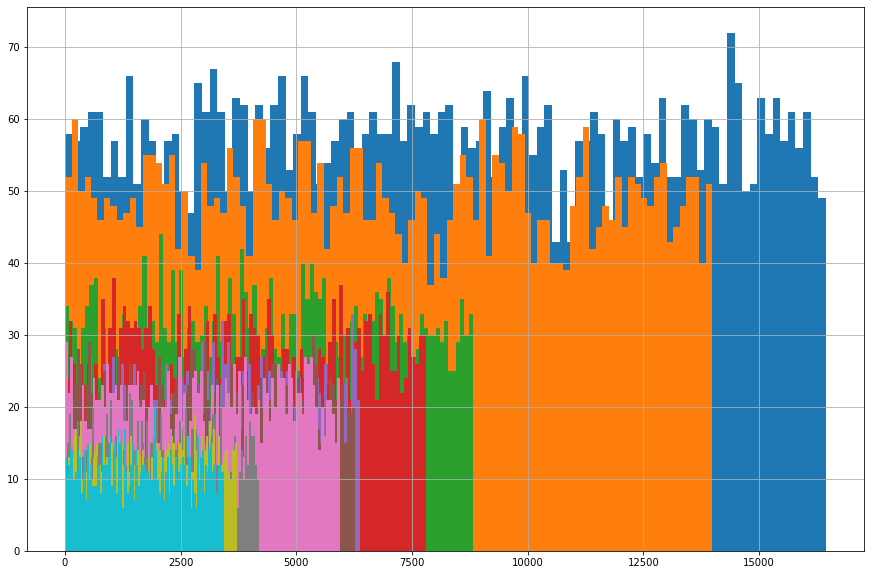

In [1185]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

<AxesSubplot:>

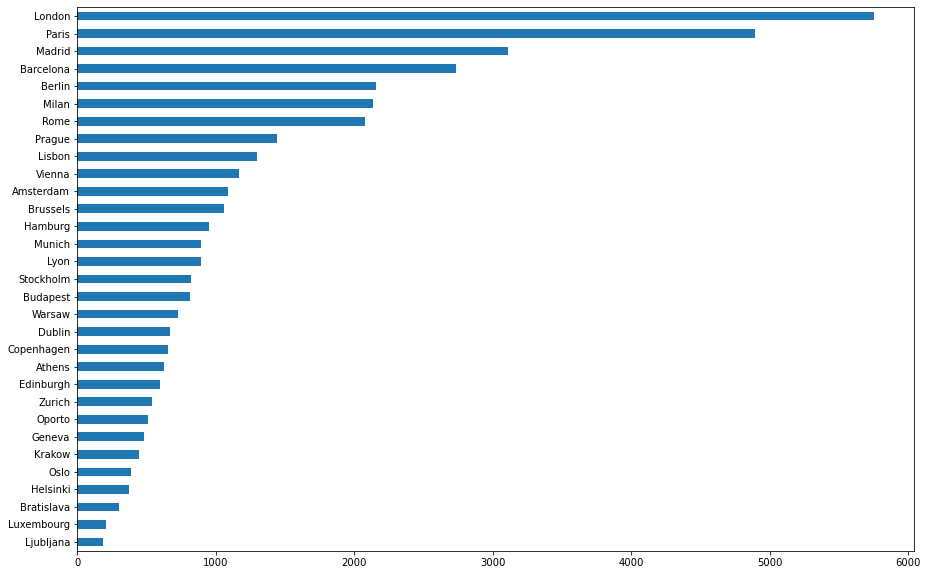

In [1186]:
# Информация по городам
df_train['City'].value_counts(ascending=True).plot(kind='barh')

<AxesSubplot:>

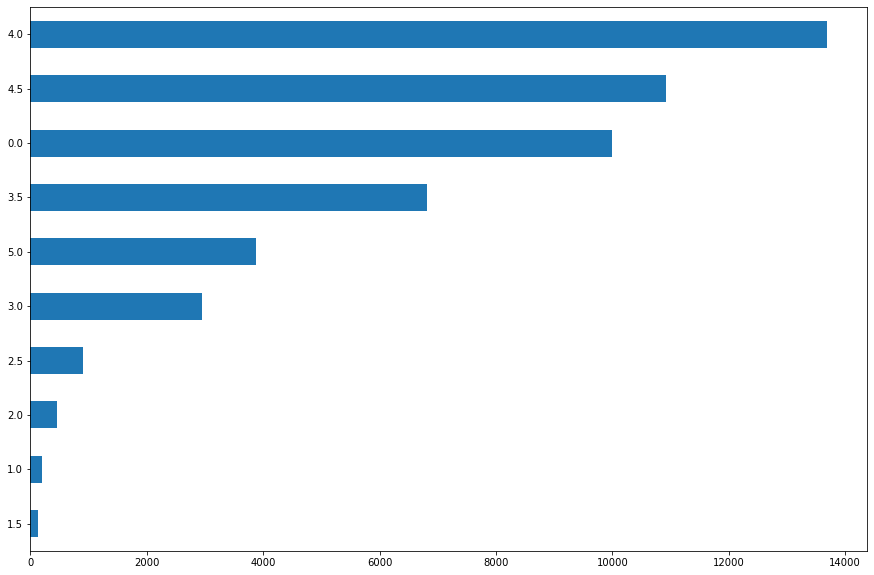

In [1182]:
# Посмотрим распределение целевой переменной
df_output['Rating'].value_counts(ascending=True).plot(kind='barh')

<AxesSubplot:>

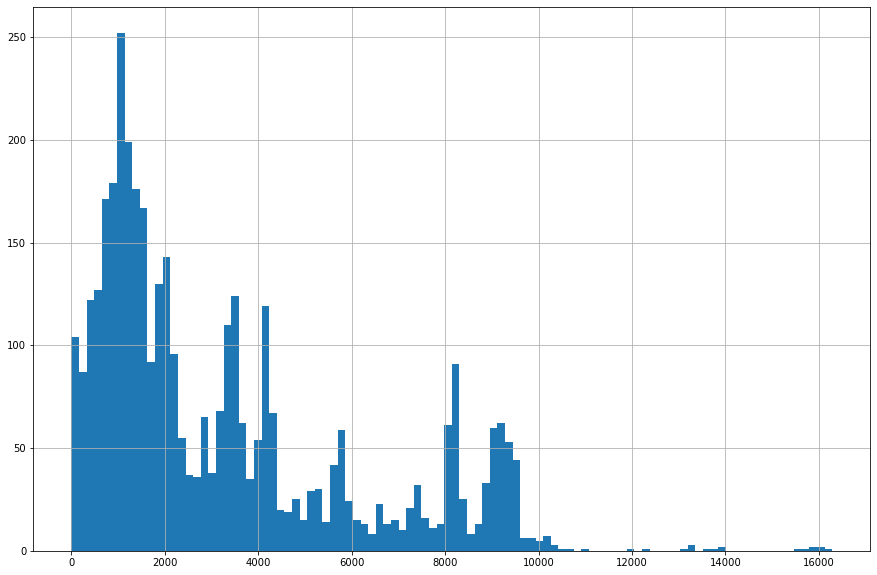

In [1181]:
# Посмотрим распределение целевой переменной относительно признака
df_output['Ranking'][df_output['Rating'] == 5].hist(bins=100)

<AxesSubplot:>

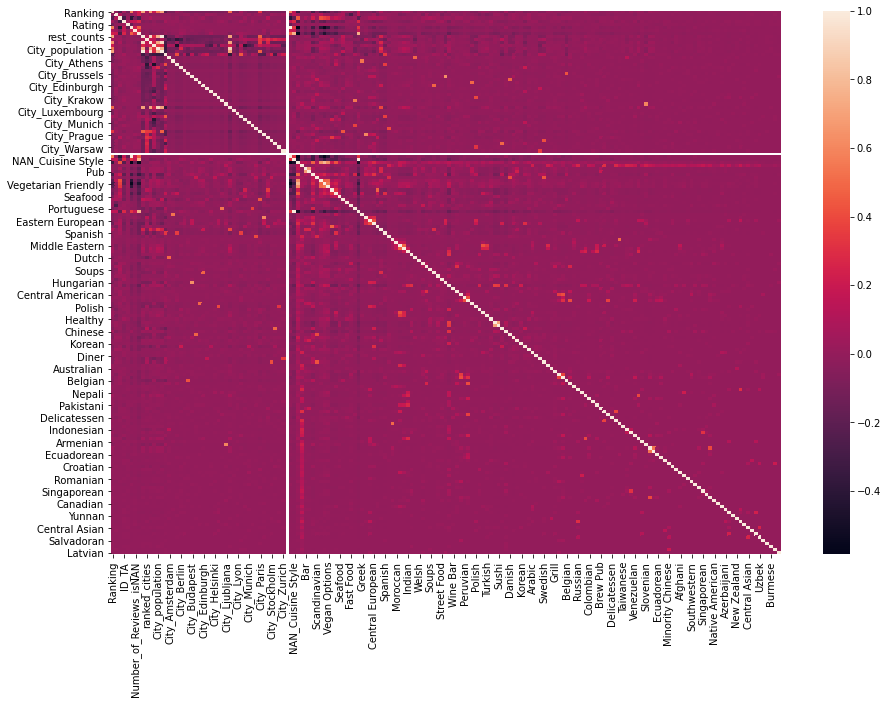

In [1180]:
# Корреляция
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df_output.drop(['sample'], axis=1).corr(),)

In [1160]:
# Удаляем не нужные столбцы
object_columns = [
    s for s in df_output.columns if df_output[s].dtypes == 'object']
df_output.drop(object_columns, axis=1, inplace=True)

In [1161]:
df_preproc = df_output

In [1162]:
df_preproc.sample(10)

,Ranking,Price,Number of Reviews,ID_TA,sample,Rating,Ranking_min_max,Number_of_Reviews_isNAN,NaN_Price Range,rest_counts,...,Albanian,Central Asian,Polynesian,Caucasian,Uzbek,Salvadoran,Xinjiang,Burmese,Fujian,Latvian
20671,7850.0,1.0,21.0,6514472,1,3.5,0.891122,0,1.0,3813,...,0,0,0,0,0,0,0,0,0,0
45414,3106.0,1.0,322.0,1351573,1,4.0,0.188834,0,0.0,7193,...,0,0,0,0,0,0,0,0,0,0
22101,4896.0,0.0,52.0,10538275,1,4.0,0.297695,0,0.0,7193,...,0,0,0,0,0,0,0,0,0,0
43000,643.0,0.0,180.0,3516138,1,4.5,0.102327,0,0.0,2694,...,0,0,0,0,0,0,0,0,0,0
12988,6547.0,1.0,216.0,3179383,1,3.0,0.839687,0,0.0,3395,...,0,0,0,0,0,0,0,0,0,0
12581,6811.0,1.0,22.0,8067323,1,4.5,0.414158,0,0.0,7193,...,0,0,0,0,0,0,0,0,0,0
42358,1506.0,1.0,4.0,12995096,1,5.0,0.564728,1,1.0,1126,...,0,0,0,0,0,0,0,0,0,0
8039,929.0,1.0,16.0,4364360,0,0.0,0.656738,0,0.0,590,...,0,0,0,0,0,0,0,0,0,0
11777,8374.0,1.0,27.0,1156795,1,4.0,0.509214,0,0.0,7193,...,0,0,0,0,0,0,0,0,0,0
15696,1998.0,1.0,24.0,3673120,1,4.0,0.580017,0,0.0,1443,...,0,0,0,0,0,0,0,0,0,0


## Начинаем делать ML
- Выделение данных

- Выбор модели

- Обучение модели

In [1163]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [1164]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [1165]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 177), (40000, 177), (40000, 176), (32000, 176), (8000, 176))

In [1166]:
model = RandomForestRegressor(
    n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [1167]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


## Наш результат

In [1168]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.19880062499999998


<AxesSubplot:>

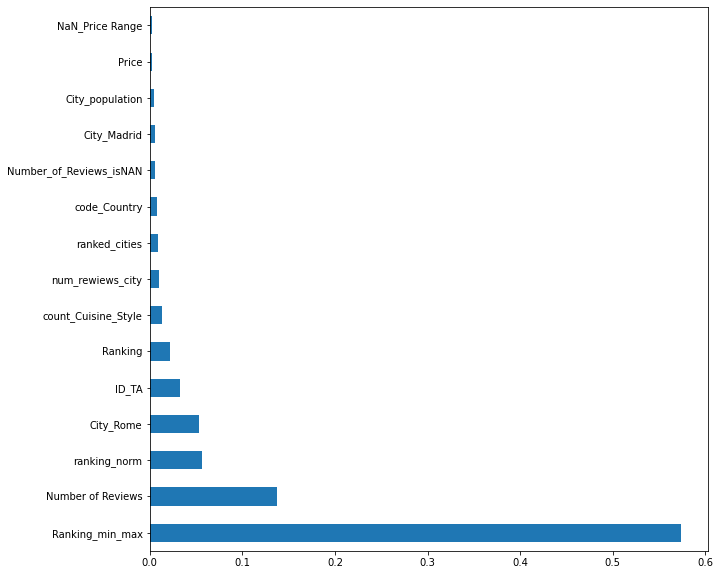

In [1169]:
# самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10, 10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

## Submission
- Готовим Submission на кагл

In [1170]:
test_data.sample(10)

,Ranking,Price,Number of Reviews,ID_TA,Rating,Ranking_min_max,Number_of_Reviews_isNAN,NaN_Price Range,rest_counts,ranked_cities,...,Albanian,Central Asian,Polynesian,Caucasian,Uzbek,Salvadoran,Xinjiang,Burmese,Fujian,Latvian
4029,7278.0,1.0,61.0,7346916,0.0,0.442559,0,0.0,7193,21634.0,...,0,0,0,0,0,0,0,0,0,0
110,178.0,1.0,52.0,6013019,0.0,0.284330,0,0.0,263,25362.0,...,0,0,0,0,0,0,0,0,0,0
8308,2442.0,1.0,50.0,3237272,0.0,0.915947,0,0.0,1126,26056.5,...,0,0,0,0,0,0,0,0,0,0
1881,4511.0,1.0,36.0,8107914,0.0,0.322391,0,0.0,6108,38455.5,...,0,0,0,0,0,0,0,0,0,0
6537,9378.0,1.0,3.0,12511272,0.0,0.670457,0,0.0,6108,38455.5,...,0,0,0,0,0,0,0,0,0,0
7370,10675.0,1.0,4.0,12133777,0.0,0.763212,1,1.0,6108,38455.5,...,0,0,0,0,0,0,0,0,0,0
601,5730.0,1.0,68.0,3737984,0.0,0.409569,0,0.0,6108,38455.5,...,0,0,0,0,0,0,0,0,0,0
6175,6341.0,0.0,66.0,8830076,0.0,0.813246,0,0.0,3395,3846.0,...,0,0,0,0,0,0,0,0,0,0
8795,7226.0,1.0,2.0,3896899,0.0,0.820277,0,1.0,3813,28526.0,...,0,0,0,0,0,0,0,0,0,0
2247,6001.0,0.0,42.0,4570532,0.0,0.364897,0,0.0,7193,21634.0,...,0,0,0,0,0,0,0,0,0,0


In [1171]:
test_data = test_data.drop(['Rating'], axis=1)

In [1172]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [1173]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


In [1174]:
predict_submission

array([3.02 , 4.24 , 4.115, ..., 3.045, 4.47 , 4.16 ])

In [1175]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.020
1,id_1,4.240
2,id_2,4.115
3,id_3,4.380
4,id_4,4.460
5,id_5,4.490
6,id_6,2.050
7,id_7,3.260
8,id_8,4.175
9,id_9,4.635
